In [1]:
# Our standard imports:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, animation
%matplotlib inline
import netCDF4 as nc
import cartopy.crs as ccrs
from netCDF4 import Dataset
from netCDF4 import num2date
import xarray as xr
import pandas as pd
import cmocean
import xgcm

#plt.rcParams['figure.dpi'] = 200 #if I will ever need a bigger pic resolution

import  glob 

In [2]:
fn_eta = sorted(glob.glob('eta_field_h5/*.h5'))

In [3]:
ds = xr.open_dataset(fn_eta[0])
ds

<xarray.Dataset>
Dimensions:     (phony_dim_0: 24, phony_dim_1: 912, phony_dim_2: 1125)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    Eta         (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    lat_region  (phony_dim_2) float32 ...
    lon_region  (phony_dim_1) float32 ...

In [4]:
def lonlat_from_frame(fname):
    with Dataset(fname) as nc:
        lon = nc['lon_region'][:]
        lat = nc['lat_region'][:]
    return lon, lat
lon, lat = lonlat_from_frame(fn_eta[0])
print(lon[[0, -1]], lon[1]-lon[0])
print(lat[[0, -1]], lat[1]-lat[0])

[118.010414 136.98958 ] 0.020835876
[18.006287 36.986065] 0.018222809


In [5]:
def daily_mean_eta(fname):
    with Dataset(fname) as nc:
        eta = nc['Eta'][:].mean(axis=0)   
    return eta

In [6]:
eta_daily = np.zeros([len(fn_eta),912,1125])
for i in range(len(fn_eta)):
    eta_daily[i,:,:] = daily_mean_eta(fn_eta[i])

In [7]:
ssh = xr.Dataset({'ssh':(['time','x','y'], eta_daily)}, 
                 coords={'lon': (['x',], lon),
                        'lat': (['y'], lat),
                        'time': pd.date_range('2011-11-01', periods=366)})

In [8]:
ssh_monthly= ssh.ssh.groupby('time.month').mean(dim='time')

/Users/ynorden/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
#My East China Sea region
lonlim = [118.010414, 136.98958]
latlim = [18.006287, 36.986065]

Text(0.5, 1.0, 'SSH East China Sea February 2012')

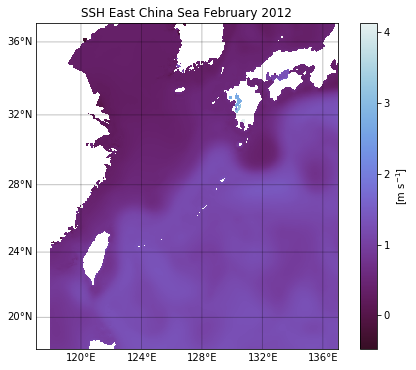

In [10]:
from pycurrents.plot.maptools import mapper, mercator, conic, llticks

x,y = np.meshgrid(lon, lat)
fig, ax = plt.subplots(figsize=(8, 6))
m = mapper(lonlim, latlim, projection='mercator',ax=ax)
m.grid()
cs = m.pcolormesh(x, y, ssh_monthly[3].T, latlon=True,cmap=cmocean.cm.dense_r)
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label("[m s$^{-1}$]")
ax.set_title('SSH East China Sea February 2012')

In [11]:
from xgcm.grid import Grid
grid = Grid(ds, periodic=['X'])

In [12]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>